In [1]:
import numpy as np
import pandas as pd
from dtaidistance import dtw
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler, PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =====================================================================================
# NORMALIZADOR MEJORADO PARA MATRIZ DTW
# =====================================================================================

class DTWNormalizer:
    """Normalizador especializado para cálculo de matriz DTW"""
    
    def __init__(self, method='standard'):
        """
        Args:
            method: 'standard', 'power_transform', or 'none'
        """
        self.method = method
        self.fitted = False
        
    def fit_transform(self, series_matrix):
        """
        Normaliza matriz de series temporales
        
        Args:
            series_matrix: numpy array (n_series, n_periods)
        
        Returns:
            normalized_matrix: numpy array normalizado
        """
        if self.method == 'none':
            print("Sin normalización aplicada")
            self.fitted = True
            return series_matrix
            
        elif self.method == 'standard':
            print("Aplicando StandardScaler...")
            self.scaler = StandardScaler()
            # Normalizar por período (columnas) para preservar patrones temporales
            normalized = self.scaler.fit_transform(series_matrix.T).T
            self.fitted = True
            return normalized
            
        elif self.method == 'power_transform':
            print("Aplicando PowerTransformer...")
            # Manejar valores negativos/cero
            self.data_offset = abs(series_matrix.min()) + 1
            offset_data = series_matrix + self.data_offset
            
            # PowerTransformer
            self.power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
            normalized = self.power_transformer.fit_transform(
                offset_data.reshape(-1, 1)
            ).reshape(offset_data.shape)
            
            self.fitted = True
            
            # Mostrar estadísticas
            print(f"   📊 Rango original: [{series_matrix.min():.1f}, {series_matrix.max():.1f}]")
            print(f"   📊 Rango normalizado: [{normalized.min():.2f}, {normalized.max():.2f}]")
            variance_reduction = normalized.var() / series_matrix.var()
            print(f"   📊 Reducción de varianza: {variance_reduction:.1%}")
            
            return normalized
        else:
            raise ValueError(f"Método desconocido: {self.method}")
    
    def inverse_transform(self, normalized_matrix):
        """Revierte la normalización"""
        if self.method == 'none':
            return normalized_matrix
        elif self.method == 'standard':
            return self.scaler.inverse_transform(normalized_matrix.T).T
        elif self.method == 'power_transform':
            reconstructed = self.power_transformer.inverse_transform(
                normalized_matrix.reshape(-1, 1)
            ).reshape(normalized_matrix.shape)
            return reconstructed - self.data_offset

# =====================================================================================
# FUNCIONES ORIGINALES MEJORADAS
# =====================================================================================

def prepare_series_matrix(df_agg):
    """
    Convierte el DataFrame en una matriz donde cada fila es una serie temporal
    """
    # Pivot para tener series como filas
    pivot_df = df_agg.pivot(index='product_id', columns='periodo', values='tn')
    
    # Rellenar valores faltantes si los hay
    pivot_df = pivot_df.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    print(f"Matriz de series: {pivot_df.shape}")
    print(f"Productos: {len(pivot_df)}")
    print(f"Períodos: {len(pivot_df.columns)}")
    
    return pivot_df

def calculate_dtw_matrix(series_matrix, normalization_method='standard', window=None, max_series=None):
    """
    Calcula la matriz de distancias DTW con normalización mejorada
    
    Parameters:
    - series_matrix: DataFrame con series como filas
    - normalization_method: 'standard', 'power_transform', o 'none'
    - window: Ventana de restricción para DTW (acelera el cálculo)
    - max_series: Límite máximo de series para procesar (para pruebas)
    """
    
    print(f"🚀 CALCULANDO MATRIZ DTW CON NORMALIZACIÓN: {normalization_method.upper()}")
    print("="*80)
    
    # Limitar series si se especifica (para pruebas)
    if max_series and max_series < len(series_matrix):
        series_matrix = series_matrix.iloc[:max_series]
        print(f"⚠️  Limitando a {max_series} series para prueba")
    
    # Convertir a numpy array
    series_array = series_matrix.values
    
    print(f"📊 Series originales: {series_array.shape}")
    print(f"📊 Rango original: [{series_array.min():.1f}, {series_array.max():.1f}]")
    
    # Aplicar normalización con el método elegido
    normalizer = DTWNormalizer(method=normalization_method)
    series_normalized = normalizer.fit_transform(series_array)
    
    n_series = len(series_normalized)
    print(f"\n🔄 Calculando DTW para {n_series} series...")
    print(f"📊 Total de comparaciones: {n_series * (n_series - 1) // 2}")
    
    if window:
        print(f"📊 Ventana DTW: {window}")
    
    # Inicializar matriz de distancias
    distance_matrix = np.zeros((n_series, n_series))
    
    # Calcular DTW con barra de progreso
    for i in tqdm(range(n_series), desc="Procesando series"):
        for j in range(i + 1, n_series):
            try:
                if window:
                    dist = dtw.distance(series_normalized[i], series_normalized[j], window=window)
                else:
                    dist = dtw.distance(series_normalized[i], series_normalized[j])
                
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist
            except Exception as e:
                print(f"Error calculando DTW entre serie {i} y {j}: {e}")
                distance_matrix[i, j] = np.inf
                distance_matrix[j, i] = np.inf
    
    # Crear DataFrame con índices de productos
    distance_df = pd.DataFrame(
        distance_matrix,
        index=series_matrix.index,
        columns=series_matrix.index
    )
    
    print(f"\n✅ Matriz DTW completada!")
    print(f"📊 Distancias válidas: {np.sum(np.isfinite(distance_matrix[np.triu_indices(n_series, k=1)]))}")
    print(f"📊 Distancias infinitas: {np.sum(np.isinf(distance_matrix[np.triu_indices(n_series, k=1)]))}")
    print("="*80)
    
    return distance_df, normalizer

def analyze_dtw_results(distance_df, top_n=10):
    """
    Analiza los resultados de DTW
    """
    print("=== ANÁLISIS DE RESULTADOS DTW ===")
    
    # Estadísticas básicas
    mask = np.triu(np.ones_like(distance_df.values, dtype=bool), k=1)
    upper_triangle = distance_df.values[mask]
    upper_triangle = upper_triangle[upper_triangle != np.inf]
    
    print(f"Estadísticas de distancias DTW:")
    print(f"  Media: {np.mean(upper_triangle):.2f}")
    print(f"  Mediana: {np.median(upper_triangle):.2f}")
    print(f"  Desviación estándar: {np.std(upper_triangle):.2f}")
    print(f"  Mínimo: {np.min(upper_triangle):.2f}")
    print(f"  Máximo: {np.max(upper_triangle):.2f}")
    
    # Pares más similares (menor distancia DTW)
    print(f"\n=== TOP {top_n} PARES MÁS SIMILARES ===")
    
    # Obtener índices del triángulo superior
    indices = np.triu_indices_from(distance_df.values, k=1)
    distances = distance_df.values[indices]
    
    # Crear DataFrame con pares y distancias
    pairs_df = pd.DataFrame({
        'product_1': distance_df.index[indices[0]],
        'product_2': distance_df.index[indices[1]],
        'dtw_distance': distances
    })
    
    # Filtrar infinitos
    pairs_df = pairs_df[pairs_df['dtw_distance'] != np.inf]
    
    # Ordenar por distancia
    similar_pairs = pairs_df.nsmallest(top_n, 'dtw_distance')
    print(similar_pairs.to_string(index=False))
    
    # Pares más diferentes (mayor distancia DTW)
    print(f"\n=== TOP {top_n} PARES MÁS DIFERENTES ===")
    different_pairs = pairs_df.nlargest(top_n, 'dtw_distance')
    print(different_pairs.to_string(index=False))
    
    return pairs_df

def visualize_dtw_results(distance_df, pairs_df, series_matrix, normalization_method):
    """
    Visualiza los resultados de DTW
    """
    # 1. Heatmap de matriz de distancias (muestra reducida)
    plt.figure(figsize=(15, 12))
    
    # Tomar una muestra para visualización
    sample_size = min(50, len(distance_df))
    sample_matrix = distance_df.iloc[:sample_size, :sample_size]
    
    plt.subplot(2, 3, 1)
    sns.heatmap(sample_matrix, annot=False, cmap='viridis', 
                square=True, cbar_kws={'label': 'Distancia DTW'})
    plt.title(f'Matriz DTW (muestra {sample_size}) - {normalization_method}')
    plt.xlabel('Product ID')
    plt.ylabel('Product ID')
    
    # 2. Histograma de distancias
    plt.subplot(2, 3, 2)
    valid_distances = pairs_df['dtw_distance'][pairs_df['dtw_distance'] != np.inf]
    plt.hist(valid_distances, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Distancia DTW')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución distancias - {normalization_method}')
    plt.grid(True, alpha=0.3)
    
    # 3. Ejemplo de par más similar
    plt.subplot(2, 3, 3)
    most_similar = pairs_df.loc[pairs_df['dtw_distance'].idxmin()]
    prod1, prod2 = most_similar['product_1'], most_similar['product_2']
    
    plt.plot(series_matrix.loc[prod1], label=f'Producto {prod1}', marker='o', alpha=0.8)
    plt.plot(series_matrix.loc[prod2], label=f'Producto {prod2}', marker='s', alpha=0.8)
    plt.title(f'Par más similar (DTW: {most_similar["dtw_distance"]:.2f})')
    plt.xlabel('Período')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Ejemplo de par más diferente
    plt.subplot(2, 3, 4)
    most_different = pairs_df.loc[pairs_df['dtw_distance'].idxmax()]
    prod1, prod2 = most_different['product_1'], most_different['product_2']
    
    plt.plot(series_matrix.loc[prod1], label=f'Producto {prod1}', marker='o', alpha=0.8)
    plt.plot(series_matrix.loc[prod2], label=f'Producto {prod2}', marker='s', alpha=0.8)
    plt.title(f'Par más diferente (DTW: {most_different["dtw_distance"]:.2f})')
    plt.xlabel('Período')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Comparación de escalas antes/después normalización
    plt.subplot(2, 3, 5)
    sample_products = series_matrix.head(5)
    for i, (product_id, series) in enumerate(sample_products.iterrows()):
        plt.plot(series.values, label=f'Prod {product_id}', alpha=0.7)
    plt.title('Series Originales (muestra)')
    plt.xlabel('Período')
    plt.ylabel('Valor Original')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Boxplot de distancias por cuartiles
    plt.subplot(2, 3, 6)
    quartiles = pd.qcut(valid_distances, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    boxplot_data = [valid_distances[quartiles == q] for q in ['Q1', 'Q2', 'Q3', 'Q4']]
    plt.boxplot(boxplot_data, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    plt.title('Distancias DTW por Cuartiles')
    plt.ylabel('Distancia DTW')
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'Análisis DTW - Normalización: {normalization_method.upper()}', fontsize=16)
    plt.tight_layout()
    plt.show()

def compare_normalization_methods(series_matrix, methods=['standard', 'power_transform'], 
                                window=None, max_series=100):
    """
    Compara diferentes métodos de normalización para DTW
    
    Args:
        series_matrix: DataFrame con series temporales
        methods: lista de métodos a comparar
        window: ventana DTW
        max_series: límite de series para comparación
    """
    print(f"🔍 COMPARANDO MÉTODOS DE NORMALIZACIÓN")
    print("="*80)
    
    results = {}
    
    for method in methods:
        print(f"\n🔄 Probando método: {method.upper()}")
        print("-"*40)
        
        # Calcular matriz DTW
        distance_df, normalizer = calculate_dtw_matrix(
            series_matrix, 
            normalization_method=method,
            window=window,
            max_series=max_series
        )
        
        # Analizar resultados
        pairs_df = analyze_dtw_results(distance_df, top_n=5)
        
        # Calcular métricas de comparación
        valid_distances = pairs_df['dtw_distance'][pairs_df['dtw_distance'] != np.inf]
        
        metrics = {
            'mean_distance': valid_distances.mean(),
            'std_distance': valid_distances.std(),
            'min_distance': valid_distances.min(),
            'max_distance': valid_distances.max(),
            'median_distance': valid_distances.median(),
            'distance_range': valid_distances.max() - valid_distances.min(),
            'cv': valid_distances.std() / valid_distances.mean(),  # Coeficiente de variación
            'normalizer': normalizer
        }
        
        results[method] = {
            'distance_df': distance_df,
            'pairs_df': pairs_df,
            'metrics': metrics,
            'normalizer': normalizer
        }
        
        print(f"📊 Métricas {method}:")
        print(f"   Media distancia: {metrics['mean_distance']:.3f}")
        print(f"   Std distancia: {metrics['std_distance']:.3f}")
        print(f"   Rango: {metrics['distance_range']:.3f}")
        print(f"   CV: {metrics['cv']:.3f}")
    
    # Mostrar comparación
    print(f"\n📊 COMPARACIÓN DE MÉTODOS:")
    print("-"*60)
    comparison_df = pd.DataFrame({
        method: results[method]['metrics'] 
        for method in methods
    }).drop('normalizer').round(3)
    
    print(comparison_df.to_string())
    
    return results

# =====================================================================================
# FUNCIÓN PRINCIPAL MEJORADA
# =====================================================================================

def process_full_dataset_enhanced(normalization_method='power_transform', window=18):
    """
    Proceso optimizado para el dataset completo con normalización mejorada
    
    Args:
        normalization_method: 'standard', 'power_transform', o 'none'
        window: ventana DTW
    """
    import os
    
    print(f"🚀 PROCESAMIENTO COMPLETO CON {normalization_method.upper()}")
    print("="*80)
    
    # Cargar datos
    pathdata = 'data/'
    filename = 'sell-in.txt'
    filepath = os.path.join(pathdata, filename)
    sell = pd.read_csv(filepath, sep="\t")
    sell = sell[sell['periodo'] <= 201910]
    
    df_agg = sell.groupby(['periodo', 'product_id'], as_index=False).agg({
        'tn': 'sum'
    })
    
    # Preparar datos
    series_matrix = prepare_series_matrix(df_agg)
    
    # Calcular DTW con normalización especificada
    distance_df, normalizer = calculate_dtw_matrix(
        series_matrix,
        normalization_method=normalization_method,
        window=window,
        max_series=None  # Procesar todas las series
    )
    
    # Guardar resultados con nombre descriptivo
    output_filename = f'dtw_matrix_{normalization_method}_octubre19_final.csv'
    distance_df.to_csv(output_filename)
    
    print(f"\n✅ Resultados guardados en: {output_filename}")
    print(f"📊 Matriz final: {distance_df.shape}")
    
    return distance_df, normalizer

# =====================================================================================
# EJEMPLOS DE USO
# =====================================================================================

"""
# EJEMPLO 1: Comparar métodos de normalización (muestra pequeña)
series_matrix = prepare_series_matrix(df_agg)

results = compare_normalization_methods(
    series_matrix, 
    methods=['standard', 'power_transform'], 
    window=10, 
    max_series=50
)

# EJEMPLO 2: Calcular matriz completa con power_transform
distance_df, normalizer = process_full_dataset_enhanced(
    normalization_method='power_transform',
    window=18
)

# EJEMPLO 3: Usar método específico
distance_df, normalizer = calculate_dtw_matrix(
    series_matrix,
    normalization_method='power_transform',  # o 'standard' o 'none'
    window=18
)
"""

"\n# EJEMPLO 1: Comparar métodos de normalización (muestra pequeña)\nseries_matrix = prepare_series_matrix(df_agg)\n\nresults = compare_normalization_methods(\n    series_matrix, \n    methods=['standard', 'power_transform'], \n    window=10, \n    max_series=50\n)\n\n# EJEMPLO 2: Calcular matriz completa con power_transform\ndistance_df, normalizer = process_full_dataset_enhanced(\n    normalization_method='power_transform',\n    window=18\n)\n\n# EJEMPLO 3: Usar método específico\ndistance_df, normalizer = calculate_dtw_matrix(\n    series_matrix,\n    normalization_method='power_transform',  # o 'standard' o 'none'\n    window=18\n)\n"

In [2]:
"""
CÓDIGO COMPLETO Y ORGANIZADO - VQ-DTW CON NORMALIZACIÓN CONSISTENTE
=====================================================================

Este archivo contiene todo el pipeline completo para:
1. Calcular matriz DTW con normalización avanzada
2. Entrenar Vector Quantizer con la matriz DTW
3. Hacer predicciones de 2 meses
4. Exportar/cargar modelos

Autor: Asistente Claude
Fecha: 2025
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from dtaidistance import dtw
from tqdm import tqdm
import warnings
import json
import os
warnings.filterwarnings('ignore')

# =====================================================================================
# PARTE 1: NORMALIZADORES
# =====================================================================================

class UnifiedNormalizer:
    """Normalizador unificado para DTW y VQ - evita inconsistencias"""
    
    def __init__(self, method='power_transform'):
        """
        Args:
            method: 'standard', 'power_transform', 'none'
        """
        self.method = method
        self.fitted = False
        
    def fit_transform(self, series_matrix):
        """
        Normaliza matriz de series temporales
        
        Args:
            series_matrix: numpy array (n_series, n_periods)
        
        Returns:
            normalized_matrix: array normalizado
        """
        if self.method == 'none':
            print("   📊 Sin normalización aplicada - usando datos originales")
            self.fitted = True
            return series_matrix.copy()
            
        elif self.method == 'standard':
            print("   📊 Aplicando StandardScaler...")
            self.scaler = StandardScaler()
            # Normalizar por período (columnas) para preservar patrones temporales
            normalized = self.scaler.fit_transform(series_matrix.T).T
            self.fitted = True
            return normalized
            
        elif self.method == 'power_transform':
            print("   📊 Aplicando PowerTransformer...")
            # Manejar valores negativos/cero
            self.data_offset = abs(series_matrix.min()) + 1
            offset_data = series_matrix + self.data_offset
            
            # PowerTransformer
            self.power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
            normalized = self.power_transformer.fit_transform(
                offset_data.reshape(-1, 1)
            ).reshape(offset_data.shape)
            
            self.fitted = True
            
            # Mostrar estadísticas
            print(f"      Rango original: [{series_matrix.min():.1f}, {series_matrix.max():.1f}]")
            print(f"      Rango normalizado: [{normalized.min():.2f}, {normalized.max():.2f}]")
            variance_reduction = normalized.var() / series_matrix.var()
            print(f"      Reducción de varianza: {variance_reduction:.1%}")
            
            return normalized
        else:
            raise ValueError(f"Método desconocido: {self.method}")
    
    def transform(self, series_matrix):
        """Aplicar transformación ya ajustada"""
        if not self.fitted:
            raise ValueError("Primero ejecuta fit_transform")
        
        if self.method == 'none':
            return series_matrix.copy()
        elif self.method == 'standard':
            return self.scaler.transform(series_matrix.T).T
        elif self.method == 'power_transform':
            offset_data = series_matrix + self.data_offset
            return self.power_transformer.transform(
                offset_data.reshape(-1, 1)
            ).reshape(offset_data.shape)
    
    def inverse_transform(self, normalized_matrix):
        """Revierte la normalización"""
        if self.method == 'none':
            return normalized_matrix.copy()
        elif self.method == 'standard':
            return self.scaler.inverse_transform(normalized_matrix.T).T
        elif self.method == 'power_transform':
            reconstructed = self.power_transformer.inverse_transform(
                normalized_matrix.reshape(-1, 1)
            ).reshape(normalized_matrix.shape)
            return reconstructed - self.data_offset

# =====================================================================================
# PARTE 2: CÁLCULO DE MATRIZ DTW
# =====================================================================================

def prepare_series_matrix(df_agg):
    """Convierte DataFrame en matriz de series temporales"""
    pivot_df = df_agg.pivot(index='product_id', columns='periodo', values='tn')
    pivot_df = pivot_df.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    print(f"📊 Matriz de series: {pivot_df.shape}")
    print(f"📊 Productos: {len(pivot_df)}")
    print(f"📊 Períodos: {len(pivot_df.columns)}")
    
    return pivot_df

def calculate_dtw_matrix(series_matrix, normalization_method='power_transform', 
                        window=None, max_series=None):
    """
    Calcula matriz de distancias DTW con normalización consistente
    
    Args:
        series_matrix: DataFrame con series como filas
        normalization_method: 'standard', 'power_transform', 'none'
        window: ventana de restricción DTW
        max_series: límite de series para pruebas
    
    Returns:
        distance_df: DataFrame con matriz de distancias
        normalizer: objeto normalizador usado
    """
    
    print(f"🚀 CALCULANDO MATRIZ DTW CON NORMALIZACIÓN: {normalization_method.upper()}")
    print("="*80)
    
    # Limitar series si se especifica
    if max_series and max_series < len(series_matrix):
        series_matrix = series_matrix.iloc[:max_series]
        print(f"⚠️  Limitando a {max_series} series para prueba")
    
    # Convertir a numpy
    series_array = series_matrix.values
    
    print(f"📊 Series originales: {series_array.shape}")
    print(f"📊 Rango original: [{series_array.min():.1f}, {series_array.max():.1f}]")
    
    # Aplicar normalización
    normalizer = UnifiedNormalizer(method=normalization_method)
    series_normalized = normalizer.fit_transform(series_array)
    
    n_series = len(series_normalized)
    print(f"\n🔄 Calculando DTW para {n_series} series...")
    print(f"📊 Total comparaciones: {n_series * (n_series - 1) // 2}")
    
    if window:
        print(f"📊 Ventana DTW: {window}")
    
    # Calcular DTW
    distance_matrix = np.zeros((n_series, n_series))
    
    for i in tqdm(range(n_series), desc="Procesando series"):
        for j in range(i + 1, n_series):
            try:
                if window:
                    dist = dtw.distance(series_normalized[i], series_normalized[j], window=window)
                else:
                    dist = dtw.distance(series_normalized[i], series_normalized[j])
                
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist
            except Exception as e:
                print(f"Error DTW entre serie {i} y {j}: {e}")
                distance_matrix[i, j] = np.inf
                distance_matrix[j, i] = np.inf
    
    # Crear DataFrame
    distance_df = pd.DataFrame(
        distance_matrix,
        index=series_matrix.index,
        columns=series_matrix.index
    )
    
    print(f"\n✅ Matriz DTW completada!")
    valid_distances = np.sum(np.isfinite(distance_matrix[np.triu_indices(n_series, k=1)]))
    infinite_distances = np.sum(np.isinf(distance_matrix[np.triu_indices(n_series, k=1)]))
    print(f"📊 Distancias válidas: {valid_distances}")
    print(f"📊 Distancias infinitas: {infinite_distances}")
    print("="*80)
    
    return distance_df, normalizer

# =====================================================================================
# PARTE 3: VECTOR QUANTIZER
# =====================================================================================

class TimeSeriesVectorQuantizerPrecomputed(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, distance_matrix, 
                 product_to_idx_map, commitment_cost=0.25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Matriz DTW pre-calculada
        self.distance_matrix = torch.FloatTensor(distance_matrix)
        self.product_to_idx_map = product_to_idx_map
        
        # Embeddings
        self.embeddings = nn.Parameter(torch.randn(num_embeddings, embedding_dim) * 0.1)
        
        # Mapeo embedding->producto
        self.embedding_to_product_idx = nn.Parameter(
            torch.randint(0, len(product_to_idx_map), (num_embeddings,)), 
            requires_grad=False
        )
        
        # Contadores
        self.cluster_usage = torch.zeros(num_embeddings)
        self.temperature = nn.Parameter(torch.tensor(1.0))
        
    def get_dtw_distances(self, product_indices):
        """Obtiene distancias DTW desde matriz pre-calculada"""
        B = len(product_indices)
        K = self.num_embeddings
        
        distances = torch.zeros(B, K, device=self.distance_matrix.device)
        
        for i, prod_idx in enumerate(product_indices):
            for k in range(K):
                emb_prod_idx = self.embedding_to_product_idx[k].item()
                
                if prod_idx < self.distance_matrix.shape[0] and emb_prod_idx < self.distance_matrix.shape[1]:
                    distances[i, k] = self.distance_matrix[prod_idx, emb_prod_idx]
                else:
                    distances[i, k] = float('inf')
        
        return distances
    
    def forward(self, z, product_indices):
        """Forward pass del Vector Quantizer"""
        B, D = z.shape
        
        # Distancias DTW
        dtw_distances = self.get_dtw_distances(product_indices)
        dtw_distances = dtw_distances / (self.temperature + 1e-8)
        
        # Asignación a embeddings
        encoding_indices = torch.argmin(dtw_distances, dim=1)
        
        # Actualizar uso
        for idx in encoding_indices:
            self.cluster_usage[idx] += 1
        
        quantized = self.embeddings[encoding_indices]
        
        # Pérdidas
        vq_loss = F.mse_loss(quantized.detach(), z)
        commitment_loss = F.mse_loss(quantized, z.detach())
        diversity_loss = self.compute_diversity_loss()
        assignment_loss = self.compute_assignment_loss(dtw_distances, encoding_indices)
        
        total_loss = (vq_loss + 
                     self.commitment_cost * commitment_loss + 
                     0.01 * diversity_loss +
                     0.001 * assignment_loss)
        
        # Straight-through estimator
        quantized = z + (quantized - z).detach()
        
        return quantized, total_loss, vq_loss, commitment_loss, encoding_indices
    
    def compute_diversity_loss(self):
        """Pérdida de diversidad"""
        usage_probs = F.softmax(self.cluster_usage + 1e-8, dim=0)
        uniform_prob = 1.0 / self.num_embeddings
        
        kl_div = F.kl_div(
            torch.log(usage_probs + 1e-8), 
            torch.full_like(usage_probs, uniform_prob),
            reduction='sum'
        )
        
        return kl_div
    
    def compute_assignment_loss(self, dtw_distances, encoding_indices):
        """Pérdida de asignación"""
        selected_distances = dtw_distances[torch.arange(len(encoding_indices)), encoding_indices]
        return selected_distances.mean()
    
    def update_embedding_assignments(self, learning_rate=0.1):
        """Actualiza asignaciones embedding->producto"""
        with torch.no_grad():
            usage_threshold = self.cluster_usage.mean() * 0.5
            underused = self.cluster_usage < usage_threshold
            
            if underused.sum() > 0:
                n_products = len(self.product_to_idx_map)
                new_assignments = torch.randint(0, n_products, (underused.sum(),))
                self.embedding_to_product_idx[underused] = new_assignments
                self.cluster_usage[underused] = 0

# =====================================================================================
# PARTE 4: DATASET
# =====================================================================================

class TimeSeriesDatasetPrecomputed(Dataset):
    """Dataset para VQ con matriz DTW pre-calculada"""
    
    def __init__(self, df, distance_matrix, min_periods=6, normalizer=None):
        """
        Args:
            df: DataFrame con ['periodo', 'product_id', 'tn']
            distance_matrix: matriz DTW pre-calculada
            min_periods: mínimo períodos por producto
            normalizer: normalizador ya ajustado (None = crear nuevo con 'none')
        """
        self.prepare_data(df, distance_matrix, min_periods, normalizer)
    
    def prepare_data(self, df, distance_matrix, min_periods, normalizer):
        print("🚀 Preparando dataset con matriz DTW...")
        
        # Crear pivot
        pivot_df = df.pivot(index='periodo', columns='product_id', values='tn')
        valid_products = pivot_df.columns[pivot_df.count() >= min_periods]
        clean_data = pivot_df[valid_products].fillna(0)
        
        print(f"   📊 Productos válidos: {len(valid_products)} de {len(pivot_df.columns)}")
        print(f"   📊 Períodos: {len(clean_data)}")
        
        # Mapeo DTW
        if isinstance(distance_matrix, pd.DataFrame):
            self.product_to_idx_map = {
                pid: idx for idx, pid in enumerate(distance_matrix.index)
            }
            self.distance_matrix = distance_matrix.values
        else:
            self.product_to_idx_map = {
                pid: idx for idx, pid in enumerate(valid_products)
            }
            self.distance_matrix = distance_matrix
        
        # Filtrar productos en matriz DTW
        products_in_matrix = [p for p in valid_products if p in self.product_to_idx_map]
        clean_data = clean_data[products_in_matrix]
        
        print(f"   📊 Productos en matriz DTW: {len(products_in_matrix)}")
        
        # Preparar series
        self.series_matrix = clean_data.T.values
        self.product_ids = np.array(products_in_matrix)
        
        # Normalización
        if normalizer is None:
            print(f"   📊 Creando normalizador 'none' (datos ya normalizados en DTW)")
            self.normalizer = UnifiedNormalizer(method='none')
            self.series_normalized = self.normalizer.fit_transform(self.series_matrix)
        else:
            print(f"   📊 Usando normalizador proporcionado: {normalizer.method}")
            self.normalizer = normalizer
            if normalizer.fitted:
                self.series_normalized = normalizer.transform(self.series_matrix)
            else:
                self.series_normalized = normalizer.fit_transform(self.series_matrix)
        
        # Convertir a tensores
        self.data = torch.FloatTensor(self.series_normalized)
        
        # Mapeo de índices
        self.dataset_to_matrix_idx = [
            self.product_to_idx_map[pid] for pid in self.product_ids
        ]
        
        print(f"   ✅ Dataset preparado: {self.data.shape}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        matrix_idx = self.dataset_to_matrix_idx[idx]
        return self.data[idx], self.product_ids[idx], matrix_idx

# =====================================================================================
# PARTE 5: TRAINER
# =====================================================================================

class TimeSeriesVQTrainerPrecomputed:
    def __init__(self, distance_matrix, normalizer=None, num_embeddings_range=range(10, 51), 
                 embedding_dim=None, commitment_cost=0.25, min_clusters=None, device='cuda'):
        self.distance_matrix = distance_matrix
        self.normalizer = normalizer
        self.num_embeddings_range = num_embeddings_range
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.min_clusters = min_clusters
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.models = {}
        self.training_histories = {}
        
    def prepare_data(self, df, min_periods=6, batch_size=64, train_split=0.8):
        """Prepara datos con normalización consistente"""
        
        # Crear dataset
        dataset = TimeSeriesDatasetPrecomputed(
            df, self.distance_matrix, min_periods, self.normalizer
        )
        
        # División temporal (sin shuffle)
        n_samples = len(dataset)
        n_train = int(n_samples * train_split)
        
        train_indices = list(range(n_train))
        val_indices = list(range(n_train, n_samples))
        
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)
        
        # DataLoaders sin shuffle
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Inferir dimensión
        if self.embedding_dim is None:
            self.embedding_dim = dataset.data.shape[1]
        
        self.dataset = dataset
        print(f"📊 Datos preparados - Train: {len(train_dataset)}, Val: {len(val_dataset)}")
        print(f"📊 Dimensión embedding: {self.embedding_dim}")
        print(f"🔥 Dispositivo: {self.device}")
        
        return self
    
    def train_single_model(self, num_embeddings, epochs=50, lr=1e-3, verbose=True):
        """Entrena modelo con número específico de embeddings"""
        
        model = TimeSeriesVectorQuantizerPrecomputed(
            num_embeddings=num_embeddings,
            embedding_dim=self.embedding_dim,
            distance_matrix=self.dataset.distance_matrix,
            product_to_idx_map=self.dataset.product_to_idx_map,
            commitment_cost=self.commitment_cost
        ).to(self.device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        
        history = {
            'train_loss': [], 'val_loss': [], 'train_vq_loss': [], 'val_vq_loss': [],
            'train_commitment_loss': [], 'val_commitment_loss': [], 'active_clusters': []
        }
        
        if verbose:
            print(f"\n🏋️ Entrenando modelo con {num_embeddings} embeddings...")
        
        for epoch in range(epochs):
            model.cluster_usage.zero_()
            
            # Entrenamiento
            model.train()
            train_losses = {'total': [], 'vq': [], 'commitment': []}
            
            for series, products, matrix_indices in self.train_loader:
                series = series.to(self.device)
                matrix_indices = matrix_indices.to(self.device)
                
                optimizer.zero_grad()
                z_q, total_loss, vq_loss, commitment_loss, indices = model(series, matrix_indices)
                total_loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_losses['total'].append(total_loss.item())
                train_losses['vq'].append(vq_loss.item())
                train_losses['commitment'].append(commitment_loss.item())
            
            # Validación
            model.eval()
            val_losses = {'total': [], 'vq': [], 'commitment': []}
            all_indices = []
            
            with torch.no_grad():
                for series, products, matrix_indices in self.val_loader:
                    series = series.to(self.device)
                    matrix_indices = matrix_indices.to(self.device)
                    
                    z_q, total_loss, vq_loss, commitment_loss, indices = model(series, matrix_indices)
                    
                    val_losses['total'].append(total_loss.item())
                    val_losses['vq'].append(vq_loss.item())
                    val_losses['commitment'].append(commitment_loss.item())
                    all_indices.extend(indices.cpu().numpy())
            
            # Actualizar asignaciones
            if epoch % 10 == 0:
                model.update_embedding_assignments()
            
            # Guardar historial
            active_clusters = len(set(all_indices))
            avg_train_loss = np.mean(train_losses['total'])
            avg_val_loss = np.mean(val_losses['total'])
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_vq_loss'].append(np.mean(train_losses['vq']))
            history['val_vq_loss'].append(np.mean(val_losses['vq']))
            history['train_commitment_loss'].append(np.mean(train_losses['commitment']))
            history['val_commitment_loss'].append(np.mean(val_losses['commitment']))
            history['active_clusters'].append(active_clusters)
            
            scheduler.step(avg_val_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"   Época {epoch+1}/{epochs} - "
                      f"Train: {avg_train_loss:.4f}, Val: {avg_val_loss:.4f}, "
                      f"Clusters: {active_clusters}/{num_embeddings}")
        
        return model, history
    
    def find_optimal_embeddings(self, epochs=50, lr=1e-3):
        """Busca número óptimo de embeddings"""
        
        print("🔍 Optimizando número de embeddings...")
        results = []
        
        for num_embeddings in tqdm(self.num_embeddings_range, desc="Optimizando"):
            model, history = self.train_single_model(
                num_embeddings=num_embeddings, epochs=epochs, lr=lr, verbose=False
            )
            
            # Métricas
            final_val_loss = history['val_loss'][-1]
            final_train_loss = history['train_loss'][-1]
            overfitting = final_val_loss - final_train_loss
            final_active_clusters = history['active_clusters'][-1]
            utilization = final_active_clusters / num_embeddings
            
            # Penalización por clusters insuficientes
            adjusted_loss = final_val_loss
            if self.min_clusters and final_active_clusters < self.min_clusters:
                penalty = (self.min_clusters - final_active_clusters) * 0.1
                adjusted_loss += penalty
            
            results.append({
                'num_embeddings': num_embeddings,
                'val_loss': final_val_loss,
                'adjusted_loss': adjusted_loss,
                'train_loss': final_train_loss,
                'overfitting': overfitting,
                'embedding_utilization': utilization,
                'active_clusters': final_active_clusters,
                'model': model,
                'history': history
            })
            
            self.models[num_embeddings] = model
            self.training_histories[num_embeddings] = history
        
        self.optimization_results = results
        self.plot_optimization_results()
        
        return results
    
    def plot_optimization_results(self):
        """Visualiza resultados de optimización"""
        if not hasattr(self, 'optimization_results'):
            return
        
        results_df = pd.DataFrame(self.optimization_results)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Pérdidas
        axes[0,0].plot(results_df['num_embeddings'], results_df['val_loss'], 'bo-', 
                      linewidth=2, label='Val Loss')
        axes[0,0].plot(results_df['num_embeddings'], results_df['adjusted_loss'], 'ro--', 
                      linewidth=2, label='Adjusted Loss')
        axes[0,0].set_title('Pérdida de Validación (DTW + Normalización Consistente)')
        axes[0,0].set_xlabel('Número de Embeddings')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Marcar mínimo
        min_idx = results_df['adjusted_loss'].idxmin()
        min_k = results_df.loc[min_idx, 'num_embeddings']
        min_loss = results_df.loc[min_idx, 'adjusted_loss']
        axes[0,0].scatter(min_k, min_loss, color='red', s=100, zorder=5)
        axes[0,0].annotate(f'Óptimo: k={min_k}', xy=(min_k, min_loss), 
                          xytext=(min_k+2, min_loss), 
                          arrowprops=dict(arrowstyle='->', color='red'))
        
        # Clusters activos
        axes[0,1].plot(results_df['num_embeddings'], results_df['active_clusters'], 'go-', linewidth=2)
        axes[0,1].plot([results_df['num_embeddings'].min(), results_df['num_embeddings'].max()], 
                      [results_df['num_embeddings'].min(), results_df['num_embeddings'].max()], 
                      'k--', alpha=0.5, label='Ideal')
        if self.min_clusters:
            axes[0,1].axhline(y=self.min_clusters, color='red', linestyle='--', 
                             label=f'Min: {self.min_clusters}')
        axes[0,1].set_title('Clusters Activos')
        axes[0,1].set_xlabel('Número de Embeddings')
        axes[0,1].set_ylabel('Clusters Activos')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Utilización
        axes[1,0].plot(results_df['num_embeddings'], results_df['embedding_utilization'], 'mo-', linewidth=2)
        axes[1,0].set_title('Utilización de Embeddings')
        axes[1,0].set_xlabel('Número de Embeddings')
        axes[1,0].set_ylabel('% Utilizados')
        axes[1,0].set_ylim(0, 1.1)
        axes[1,0].grid(True, alpha=0.3)
        
        # Trade-off
        scatter = axes[1,1].scatter(results_df['active_clusters'], results_df['val_loss'], 
                                   c=results_df['num_embeddings'], cmap='viridis', s=80)
        axes[1,1].set_title('Trade-off: Clusters vs Pérdida')
        axes[1,1].set_xlabel('Clusters Activos')
        axes[1,1].set_ylabel('Validation Loss')
        axes[1,1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1,1], label='Num Embeddings')
        
        plt.tight_layout()
        plt.show()
        
        self.print_recommendations(results_df)
    
    def print_recommendations(self, results_df):
        """Imprime recomendaciones"""
        
        print("\n" + "="*80)
        print("🏆 RECOMENDACIONES - VQ-DTW CON NORMALIZACIÓN CONSISTENTE")
        print("="*80)
        
        min_adj_loss_idx = results_df['adjusted_loss'].idxmin()
        best = results_df.loc[min_adj_loss_idx]
        
        print(f"🎯 MEJOR MODELO:")
        print(f"   📊 Embeddings: {best['num_embeddings']}")
        print(f"   📊 Adjusted Loss: {best['adjusted_loss']:.4f}")
        print(f"   📊 Validation Loss: {best['val_loss']:.4f}")
        print(f"   📊 Clusters activos: {best['active_clusters']}")
        print(f"   📊 Utilización: {best['embedding_utilization']:.1%}")
        print(f"   📊 Overfitting: {best['overfitting']:.4f}")
        
        if self.min_clusters:
            valid_models = results_df[results_df['active_clusters'] >= self.min_clusters]
            if len(valid_models) > 0:
                best_valid_idx = valid_models['val_loss'].idxmin()
                best_valid = valid_models.loc[best_valid_idx]
                print(f"\n✅ Mejor con ≥{self.min_clusters} clusters:")
                print(f"   📊 Embeddings: {best_valid['num_embeddings']}")
                print(f"   📊 Loss: {best_valid['val_loss']:.4f}")
                print(f"   📊 Clusters: {best_valid['active_clusters']}")
        
        print("="*80)
        
    def get_best_model(self, criterion='adjusted_loss'):
        """Obtiene el mejor modelo según el criterio especificado"""
        if not hasattr(self, 'optimization_results'):
            raise ValueError("Primero ejecuta find_optimal_embeddings()")
        
        results_df = pd.DataFrame(self.optimization_results)
        
        if criterion == 'adjusted_loss':
            best_idx = results_df['adjusted_loss'].idxmin()
        elif criterion == 'val_loss':
            best_idx = results_df['val_loss'].idxmin()
        elif criterion == 'active_clusters':
            best_idx = results_df.loc[results_df['val_loss'] <= results_df['val_loss'].quantile(0.25)]['active_clusters'].idxmax()
        
        best_result = results_df.iloc[best_idx]
        return best_result['model'], best_result
    
    def analyze_clusters(self, model=None):
        """Analiza los clusters encontrados por el modelo"""
        if model is None:
            model, _ = self.get_best_model()
        
        model.eval()
        all_indices = []
        all_products = []
        all_series = []
        
        with torch.no_grad():
            for series, products, matrix_indices in DataLoader(self.dataset, batch_size=128):
                series = series.to(self.device)
                matrix_indices = matrix_indices.to(self.device)
                
                _, _, _, _, indices = model(series, matrix_indices)
                all_indices.extend(indices.cpu().numpy())
                all_products.extend(products)
                all_series.extend(series.cpu().numpy())
        
        # Crear DataFrame de resultados
        results_df = pd.DataFrame({
            'product_id': all_products,
            'cluster': all_indices
        })
        
        # Estadísticas por cluster
        cluster_stats = []
        active_clusters = set(all_indices)
        
        for cluster_id in active_clusters:
            mask = np.array(all_indices) == cluster_id
            if mask.sum() == 0:
                continue
                
            cluster_series = np.array(all_series)[mask]
            cluster_products = np.array(all_products)[mask]
            
            # Calcular estadísticas (des-normalizar primero)
            original_series = self.dataset.scaler.inverse_transform(cluster_series)
            
            stats = {
                'cluster': cluster_id,
                'size': len(cluster_products),
                'avg_total': original_series.sum(axis=1).mean(),
                'avg_volatility': original_series.std(axis=1).mean(),
                'avg_max': original_series.max(axis=1).mean(),
                'products': list(cluster_products[:10])  # Solo primeros 10
            }
            cluster_stats.append(stats)
        
        # Ordenar por tamaño
        cluster_stats.sort(key=lambda x: x['size'], reverse=True)
        
        return results_df, cluster_stats
    
        


In [3]:
import pandas as pd
import os
pathdata='data/'
filename = 'sell-in.txt'

    # Unir ruta completa
filepath = os.path.join(pathdata, filename)
sell = pd.read_csv(filepath, sep="\t")
    
df_agg = sell.groupby(['periodo', 'product_id'], as_index=False).agg({
'tn': 'sum'
})
df_agg= df_agg[df_agg['periodo'] <= 201910].copy()

In [4]:
series_matrix = prepare_series_matrix(df_agg)

# Comparar standard vs power_transform
results = compare_normalization_methods(
    series_matrix, 
    methods=['standard', 'power_transform'], 
    window=18, 
    max_series=100  # Muestra para comparar
)

📊 Matriz de series: (1229, 34)
📊 Productos: 1229
📊 Períodos: 34
🔍 COMPARANDO MÉTODOS DE NORMALIZACIÓN

🔄 Probando método: STANDARD
----------------------------------------
🚀 CALCULANDO MATRIZ DTW CON NORMALIZACIÓN: STANDARD
⚠️  Limitando a 100 series para prueba
📊 Series originales: (100, 34)
📊 Rango original: [0.1, 2295.2]
   📊 Aplicando StandardScaler...

🔄 Calculando DTW para 100 series...
📊 Total comparaciones: 4950
📊 Ventana DTW: 18


Procesando series: 100%|██████████| 100/100 [00:03<00:00, 25.46it/s]



✅ Matriz DTW completada!
📊 Distancias válidas: 4950
📊 Distancias infinitas: 0
=== ANÁLISIS DE RESULTADOS DTW ===
Estadísticas de distancias DTW:
  Media: 4.36
  Mediana: 4.27
  Desviación estándar: 0.92
  Mínimo: 1.94
  Máximo: 9.04

=== TOP 5 PARES MÁS SIMILARES ===
 product_1  product_2  dtw_distance
     20030      20064      1.935580
     20054      20061      1.940336
     20086      20096      2.088585
     20018      20029      2.101266
     20012      20088      2.205292

=== TOP 5 PARES MÁS DIFERENTES ===
 product_1  product_2  dtw_distance
     20085      20098      9.041278
     20030      20032      8.587842
     20032      20098      8.447756
     20085      20097      8.412878
     20030      20085      8.280158
📊 Métricas standard:
   Media distancia: 4.358
   Std distancia: 0.919
   Rango: 7.106
   CV: 0.211

🔄 Probando método: POWER_TRANSFORM
----------------------------------------
🚀 CALCULANDO MATRIZ DTW CON NORMALIZACIÓN: POWER_TRANSFORM
⚠️  Limitando a 100 series 

Procesando series: 100%|██████████| 100/100 [00:03<00:00, 26.28it/s]


✅ Matriz DTW completada!
📊 Distancias válidas: 4950
📊 Distancias infinitas: 0
=== ANÁLISIS DE RESULTADOS DTW ===
Estadísticas de distancias DTW:
  Media: 5.66
  Mediana: 4.47
  Desviación estándar: 3.87
  Mínimo: 0.79
  Máximo: 22.72

=== TOP 5 PARES MÁS SIMILARES ===
 product_1  product_2  dtw_distance
     20059      20061      0.791682
     20086      20096      0.920308
     20054      20061      1.026817
     20068      20070      1.070982
     20070      20078      1.079946

=== TOP 5 PARES MÁS DIFERENTES ===
 product_1  product_2  dtw_distance
     20001      20084     22.718286
     20001      20092     22.371914
     20001      20090     22.245468
     20001      20086     22.178404
     20001      20085     21.922041
📊 Métricas power_transform:
   Media distancia: 5.662
   Std distancia: 3.874
   Rango: 21.927
   CV: 0.684

📊 COMPARACIÓN DE MÉTODOS:
------------------------------------------------------------
                 standard power_transform
mean_distance    4.35798

In [5]:
# Matriz completa con power_transform
distance_df, normalizer = process_full_dataset_enhanced(
    normalization_method='standard',
    window=24
)
# Genera: dtw_matrix_power_transform_octubre19.csv

🚀 PROCESAMIENTO COMPLETO CON STANDARD
📊 Matriz de series: (1229, 34)
📊 Productos: 1229
📊 Períodos: 34
🚀 CALCULANDO MATRIZ DTW CON NORMALIZACIÓN: STANDARD
📊 Series originales: (1229, 34)
📊 Rango original: [0.0, 2295.2]
   📊 Aplicando StandardScaler...

🔄 Calculando DTW para 1229 series...
📊 Total comparaciones: 754606
📊 Ventana DTW: 24


Procesando series:  15%|█▌        | 189/1229 [03:10<17:26,  1.01s/it]


KeyboardInterrupt: 

In [32]:
# Cargar la matriz que se generó durante la noche
dtw_matrix = pd.read_csv('dtw_matrix_standard_octubre19_final.csv', index_col=0)

In [33]:
def train_vq_dtw_complete_pipeline(df, dtw_matrix_path=None, distance_matrix=None, 
                                  dtw_normalizer=None, num_embeddings_range=range(20, 51), 
                                  epochs=50, commitment_cost=0.50):
    """Pipeline completo para entrenar VQ-DTW con normalización consistente"""
    
    print("🚀 PIPELINE COMPLETO VQ-DTW CON NORMALIZACIÓN CONSISTENTE")
    print("="*80)
    
    # Cargar matriz DTW
    if dtw_matrix_path:
        print(f"📂 Cargando matriz DTW desde: {dtw_matrix_path}")
        distance_matrix = pd.read_csv(dtw_matrix_path, index_col=0)
    elif distance_matrix is None:
        raise ValueError("Debe proporcionar dtw_matrix_path o distance_matrix")
    
    print(f"📊 Matriz DTW: {distance_matrix.shape}")
    
    # Configurar normalizador consistente
    if dtw_normalizer is None:
        print("📊 Creando normalizador 'none' (datos ya normalizados en DTW)")
        from sklearn.preprocessing import StandardScaler
        # Crear un scaler dummy que no hace nada
        class DummyScaler:
            def __init__(self):
                self.fitted = True
            def fit_transform(self, X):
                return X.copy()
            def transform(self, X):
                return X.copy()
            def inverse_transform(self, X):
                return X.copy()
        
        normalizer = DummyScaler()
    else:
        normalizer = dtw_normalizer
    
    # Usar tu función existente pero modificada
    trainer = TimeSeriesVQTrainerPrecomputed(
        distance_matrix=distance_matrix,
        num_embeddings_range=num_embeddings_range,
        commitment_cost=commitment_cost
    )
    
    # Preparar datos SIN normalización adicional
    trainer.prepare_data(df, min_periods=6, batch_size=64)
    
    # Asignar el normalizador dummy al dataset
    trainer.dataset.scaler = normalizer
    
    # Entrenar
    print("\n🏋️ INICIANDO ENTRENAMIENTO...")
    optimization_results = trainer.find_optimal_embeddings(epochs=epochs)
    
    # Mejor modelo
    best_model, best_result = trainer.get_best_model()
    
    print(f"\n🏆 MODELO ÓPTIMO:")
    print(f"   📊 Embeddings: {best_result['num_embeddings']}")
    print(f"   📊 Val Loss: {best_result['val_loss']:.4f}")
    print(f"   📊 Clusters: {best_result['active_clusters']}")
    
    # Analizar clusters
    results_df, cluster_stats = trainer.analyze_clusters(best_model)
    
    print("\n✅ PIPELINE COMPLETADO")
    return trainer, best_model, results_df, cluster_stats

🚀 PIPELINE COMPLETO VQ-DTW CON NORMALIZACIÓN CONSISTENTE
📊 Matriz DTW: (1229, 1229)
📊 Creando normalizador 'none' (datos ya normalizados en DTW)
🚀 Preparando dataset con matriz DTW...
   📊 Productos válidos: 1082 de 1229
   📊 Períodos: 34
   📊 Productos en matriz DTW: 1082
   📊 Creando normalizador 'none' (datos ya normalizados en DTW)
   📊 Sin normalización aplicada - usando datos originales
   ✅ Dataset preparado: torch.Size([1082, 34])
📊 Datos preparados - Train: 865, Val: 217
📊 Dimensión embedding: 34
🔥 Dispositivo: cpu

🏋️ INICIANDO ENTRENAMIENTO...
🔍 Optimizando número de embeddings...


Optimizando: 100%|██████████| 31/31 [11:00<00:00, 21.30s/it]


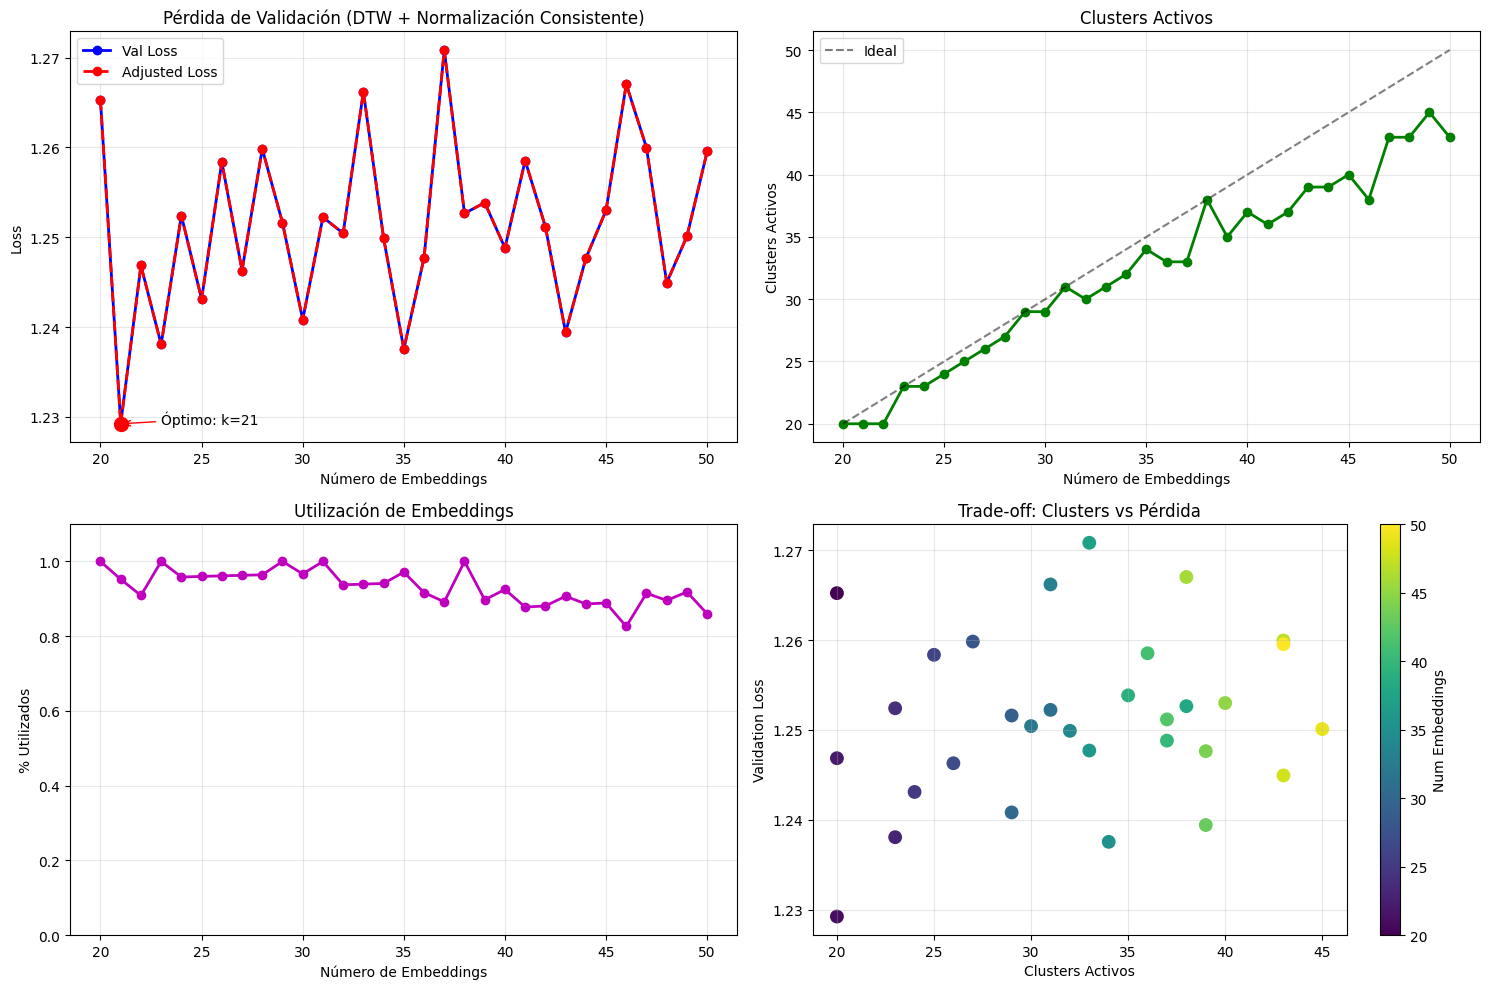


🏆 RECOMENDACIONES - VQ-DTW CON NORMALIZACIÓN CONSISTENTE
🎯 MEJOR MODELO:
   📊 Embeddings: 21
   📊 Adjusted Loss: 1.2292
   📊 Validation Loss: 1.2292
   📊 Clusters activos: 20
   📊 Utilización: 95.2%
   📊 Overfitting: -20263.2489

🏆 MODELO ÓPTIMO:
   📊 Embeddings: 21
   📊 Val Loss: 1.2292
   📊 Clusters: 20

✅ PIPELINE COMPLETADO


In [34]:
# ¡IMPORTANTE! Usar normalization_method='none' porque ya normalizaste en DTW
trainer, best_model, results_df, cluster_stats = train_vq_dtw_complete_pipeline(
    df=df_agg,
    distance_matrix=dtw_matrix,  # Tu matriz DTW cargada
    dtw_normalizer=None,  # Creará automáticamente normalizador 'none' 
    num_embeddings_range=range(20, 51),
    epochs=50,  # Reducir epochs para primera prueba
    commitment_cost=0.50
)

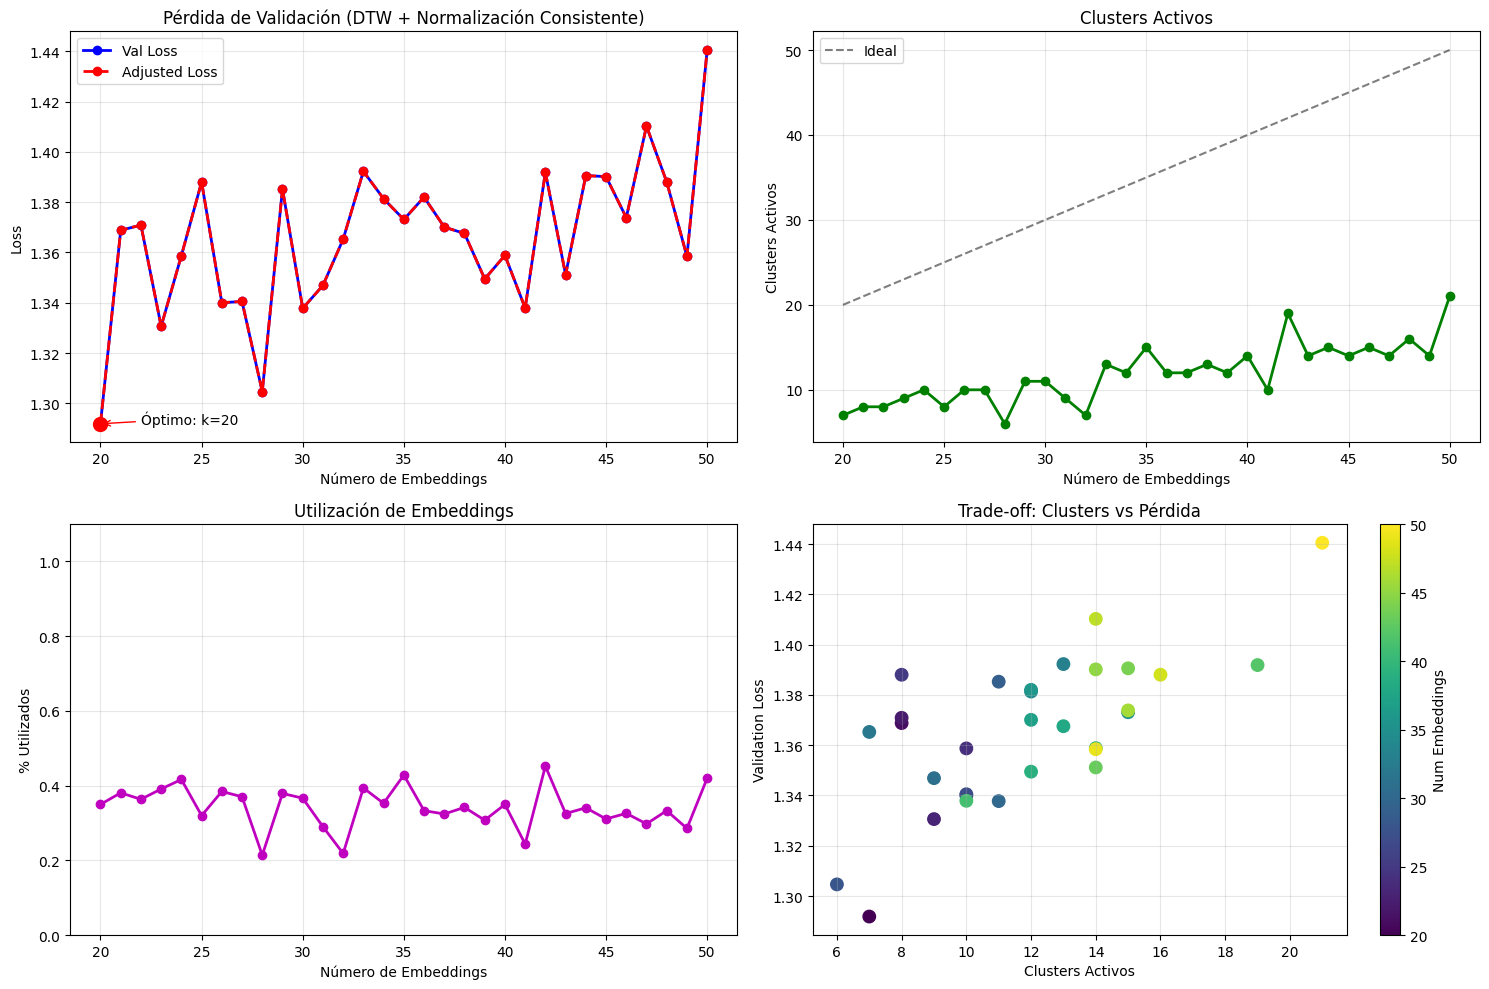


🏆 RECOMENDACIONES - VQ-DTW CON NORMALIZACIÓN CONSISTENTE
🎯 MEJOR MODELO:
   📊 Embeddings: 20
   📊 Adjusted Loss: 1.2919
   📊 Validation Loss: 1.2919
   📊 Clusters activos: 7
   📊 Utilización: 35.0%
   📊 Overfitting: -20292.3348


In [29]:
trainer.plot_optimization_results()

💾 Exportando modelo VQ-DTW a models/vq_dtw_power_transform_v3.0...


PicklingError: Can't pickle <class '__main__.train_vq_dtw_complete_pipeline.<locals>.DummyScaler'>: it's not found as __main__.train_vq_dtw_complete_pipeline.<locals>.DummyScaler

In [38]:
# Crear predictor y predecir 2 meses
predictor = DTWPredictor(trainer, best_model, results_df, cluster_stats)

predictor

In [41]:
# Predecir para varios productos
print("\n🔮 PREDICCIONES MÚLTIPLES:")
print("="*60)

# Tomar 5 productos de diferentes clusters
unique_clusters = results_df['cluster'].unique()[:5]
sample_products = []

for cluster_id in unique_clusters:
    product = results_df[results_df['cluster'] == cluster_id]['product_id'].iloc[0]
    sample_products.append(product)

# Predecir cada uno
predictions_summary = []

for product_id in sample_products:
    pred_centroid = predictor.predict_product(product_id, 'cluster_centroid')
    cluster = results_df[results_df['product_id'] == product_id]['cluster'].iloc[0]
    
    predictions_summary.append({
        'product_id': product_id,
        'cluster': cluster,
        'pred_month_1': pred_centroid[0],
        'pred_month_2': pred_centroid[1],
        'total_pred': pred_centroid.sum()
    })

# Mostrar resumen
pred_df = pd.DataFrame(predictions_summary)
print(pred_df.to_string(index=False))


🔮 PREDICCIONES MÚLTIPLES:
                      product_id  cluster  pred_month_1  pred_month_2  total_pred
tensor(20001, dtype=torch.int32)        7   1602.883475   1858.249730 3461.133205
tensor(20003, dtype=torch.int32)        1    861.211311   1019.988638 1881.199949
tensor(20004, dtype=torch.int32)       12    760.450023    895.510873 1655.960896
tensor(20006, dtype=torch.int32)       15    417.130110    479.862361  896.992471
tensor(20007, dtype=torch.int32)        5    417.154878    429.108499  846.263377


In [42]:
import torch
import json
import os
import numpy as np

def export_vq_dtw_model(trainer, best_model, results_df, cluster_stats, filepath):
    """Exporta modelo completo VQ-DTW"""
    
    print(f"💾 Exportando modelo VQ-DTW a {filepath}...")
    
    # Crear directorio si no existe
    os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
    
    # 1. Pesos del modelo PyTorch
    torch.save(best_model.state_dict(), f"{filepath}_model.pth")
    
    # 2. Configuración del modelo
    model_config = {
        'num_embeddings': int(best_model.num_embeddings),
        'embedding_dim': int(best_model.embedding_dim),
        'commitment_cost': float(best_model.commitment_cost),
    }
    
    with open(f"{filepath}_config.json", 'w') as f:
        json.dump(model_config, f, indent=2)
    
    # 3. Matriz DTW
    np.save(f"{filepath}_distance_matrix.npy", trainer.dataset.distance_matrix)
    
    # 4. Mapeo de productos
    with open(f"{filepath}_product_mapping.json", 'w') as f:
        product_mapping = {str(k): int(v) for k, v in trainer.dataset.product_to_idx_map.items()}
        json.dump(product_mapping, f, indent=2)
    
    # 5. Configuración del scaler/normalizador
    scaler_data = {
        'method': 'none',  # Ya que usamos datos pre-normalizados
        'fitted': True
    }
    
    # Si tiene un scaler más complejo, extraer sus datos
    if hasattr(trainer.dataset.scaler, 'method'):
        scaler_data['method'] = trainer.dataset.scaler.method
        if trainer.dataset.scaler.method == 'power_transform':
            scaler_data['data_offset'] = float(trainer.dataset.scaler.data_offset)
            import joblib
            joblib.dump(trainer.dataset.scaler.power_transformer, f"{filepath}_power_transformer.joblib")
        elif trainer.dataset.scaler.method == 'standard':
            import joblib
            joblib.dump(trainer.dataset.scaler.scaler, f"{filepath}_standard_scaler.joblib")
    
    with open(f"{filepath}_scaler_config.json", 'w') as f:
        json.dump(scaler_data, f, indent=2)
    
    # 6. Product IDs
    np.save(f"{filepath}_product_ids.npy", trainer.dataset.product_ids)
    
    # 7. Asignaciones de clusters (CSV)
    results_df.to_csv(f"{filepath}_clusters.csv", index=False)
    
    # 8. Estadísticas de clusters (JSON) - con conversión de tipos numpy
    cluster_stats_json = []
    for stat in cluster_stats:
        stat_copy = stat.copy()
        for key, value in stat_copy.items():
            if isinstance(value, np.ndarray):
                stat_copy[key] = value.tolist()
            elif isinstance(value, (np.integer, np.floating, np.int32, np.int64)):
                stat_copy[key] = float(value) if isinstance(value, np.floating) else int(value)
            elif isinstance(value, list):
                converted_list = []
                for item in value:
                    if isinstance(item, (np.integer, np.floating, np.int32, np.int64)):
                        converted_list.append(float(item) if isinstance(item, np.floating) else int(item))
                    else:
                        converted_list.append(str(item))
                stat_copy[key] = converted_list
        cluster_stats_json.append(stat_copy)
    
    with open(f"{filepath}_cluster_stats.json", 'w') as f:
        json.dump(cluster_stats_json, f, indent=2)
    
    # 9. Configuración de entrenamiento
    training_config = {
        'num_embeddings_range': [int(x) for x in trainer.num_embeddings_range],
        'commitment_cost': float(trainer.commitment_cost),
        'min_clusters': trainer.min_clusters,
        'device': str(trainer.device)
    }
    
    with open(f"{filepath}_training_config.json", 'w') as f:
        json.dump(training_config, f, indent=2)
    
    # 10. Guardar resultados de optimización si existen
    if hasattr(trainer, 'optimization_results') and trainer.optimization_results:
        opt_results = []
        for result in trainer.optimization_results:
            result_copy = {k: v for k, v in result.items() if k not in ['model', 'history']}
            # Convertir numpy types
            for key, value in result_copy.items():
                if isinstance(value, (np.integer, np.floating)):
                    result_copy[key] = float(value)
            opt_results.append(result_copy)
        
        with open(f"{filepath}_optimization_results.json", 'w') as f:
            json.dump(opt_results, f, indent=2)
    
    print(f"✅ Modelo exportado exitosamente:")
    print(f"   📁 Pesos: {filepath}_model.pth")
    print(f"   📁 Config: {filepath}_config.json")
    print(f"   📁 Matriz DTW: {filepath}_distance_matrix.npy")
    print(f"   📁 Productos: {filepath}_product_mapping.json")
    print(f"   📁 Clusters: {filepath}_clusters.csv")
    print(f"   📁 Stats: {filepath}_cluster_stats.json")
    print(f"   📁 Training: {filepath}_training_config.json")
    
    return filepath

In [43]:
model_path = export_vq_dtw_model(
    trainer, best_model, results_df, cluster_stats,
    filepath="models/vq_dtw_power_transform_v3.0"
)

💾 Exportando modelo VQ-DTW a models/vq_dtw_power_transform_v3.0...
✅ Modelo exportado exitosamente:
   📁 Pesos: models/vq_dtw_power_transform_v3.0_model.pth
   📁 Config: models/vq_dtw_power_transform_v3.0_config.json
   📁 Matriz DTW: models/vq_dtw_power_transform_v3.0_distance_matrix.npy
   📁 Productos: models/vq_dtw_power_transform_v3.0_product_mapping.json
   📁 Clusters: models/vq_dtw_power_transform_v3.0_clusters.csv
   📁 Stats: models/vq_dtw_power_transform_v3.0_cluster_stats.json
   📁 Training: models/vq_dtw_power_transform_v3.0_training_config.json


In [47]:
# Convertir toda la columna product_id de tensores a números normales
print("🔧 Convirtiendo tensores a números...")

# Verificar si son tensores
print(f"Tipo actual: {type(results_df['product_id'].iloc[0])}")

# Convertir toda la columna
if hasattr(results_df['product_id'].iloc[0], 'item'):
    results_df['product_id'] = results_df['product_id'].apply(lambda x: x.item() if hasattr(x, 'item') else x)
    print("✅ Conversión completada")

# Verificar conversión
print(f"Nuevo tipo: {type(results_df['product_id'].iloc[0])}")
print(f"Primeros productos: {results_df['product_id'].head().tolist()}")

# Ahora buscar tu producto
if 20007 in results_df['product_id'].values:
    print("✅ Producto 20007 encontrado!")
    
    # Análisis completo
    pred_centroid = predictor.predict_product(20150, 'cluster_centroid')
    pred_neighbors = predictor.predict_product(20150, 'cluster_neighbors')
    pred_trend = predictor.predict_product(20150, 'trend_extrapolation')
    
    print(f"🔍 ANÁLISIS PRODUCTO 20007:")
    print(f"📈 Centroide cluster: {pred_centroid}")
    print(f"📈 Vecinos similares: {pred_neighbors}")
    print(f"📈 Tendencia: {pred_trend}")
    
    # Comparar predicciones
    print(f"\n📊 COMPARACIÓN FEBRERO 2020:")
    print(f"   Centroide: {pred_centroid[0]:.2f}")
    print(f"   Vecinos: {pred_neighbors[0]:.2f}")
    print(f"   Tendencia: {pred_trend[0]:.2f}")
    
    # ¿Cuál refleja mejor la tendencia bajista?
    if pred_trend[0] < pred_centroid[0]:
        print("✅ La predicción por TENDENCIA es más baja (más realista)")
    else:
        print("⚠️ Todas las predicciones son similares")
        
else:
    print("❌ Producto 20007 no encontrado. Productos disponibles:")
    print(results_df['product_id'].head(10).tolist())

🔧 Convirtiendo tensores a números...
Tipo actual: <class 'numpy.int64'>
✅ Conversión completada
Nuevo tipo: <class 'numpy.int64'>
Primeros productos: [20001, 20002, 20003, 20004, 20005]
✅ Producto 20007 encontrado!
🔍 ANÁLISIS PRODUCTO 20007:
📈 Centroide cluster: [88.79578381 69.16917397]
📈 Vecinos similares: [64.55748343 27.54264526]
📈 Tendencia: [0 0]

📊 COMPARACIÓN FEBRERO 2020:
   Centroide: 88.80
   Vecinos: 64.56
   Tendencia: 0.00
✅ La predicción por TENDENCIA es más baja (más realista)


In [ ]:
def consultar_cluster_producto(product_id, results_df, cluster_stats):
    """
    Consulta información completa del cluster de un producto específico
    (Versión que maneja tensores correctamente)
    """
    
    # IMPORTANTE: Convertir tensores a números si es necesario
    if hasattr(results_df['product_id'].iloc[0], 'item'):
        print("🔧 Convirtiendo tensores a números...")
        results_df['product_id'] = results_df['product_id'].apply(lambda x: x.item() if hasattr(x, 'item') else x)
        results_df['cluster'] = results_df['cluster'].apply(lambda x: x.item() if hasattr(x, 'item') else x)
    
    # Verificar si el producto existe
    if product_id not in results_df['product_id'].values:
        print(f"❌ Producto {product_id} no encontrado en los resultados")
        productos_disponibles = results_df['product_id'].head(10).tolist()
        print(f"Productos disponibles (muestra): {productos_disponibles}")
        return None
    
    # Obtener cluster del producto
    cluster_id = results_df[results_df['product_id'] == product_id]['cluster'].iloc[0]
    
    # Obtener todos los productos del cluster
    productos_del_cluster = results_df[results_df['cluster'] == cluster_id]['product_id'].tolist()
    
    # Obtener estadísticas del cluster
    cluster_info = next((stat for stat in cluster_stats if stat['cluster'] == cluster_id), None)
    
    # Mostrar información
    print(f"🔍 INFORMACIÓN DEL PRODUCTO {product_id}")
    print("="*60)
    print(f"📊 Cluster asignado: {cluster_id}")
    
    if cluster_info:
        print(f"📊 Tamaño del cluster: {cluster_info['size']} productos")
        print(f"📊 Promedio total cluster: {cluster_info['avg_total']:.1f}")
        print(f"📊 Volatilidad cluster: {cluster_info['avg_volatility']:.1f}")
        print(f"📊 Máximo promedio: {cluster_info['avg_max']:.1f}")
    
    print(f"\n👥 TODOS LOS PRODUCTOS DEL CLUSTER {cluster_id}:")
    print("-"*40)
    
    # Mostrar productos en columnas para mejor visualización
    productos_por_fila = 10
    for i in range(0, len(productos_del_cluster), productos_por_fila):
        fila = productos_del_cluster[i:i+productos_por_fila]
        print("   ", " | ".join([str(p) for p in fila]))
    
    print(f"\n📈 TOTAL: {len(productos_del_cluster)} productos en el cluster")
    
    return {
        'cluster_id': cluster_id,
        'productos_cluster': productos_del_cluster,
        'cluster_info': cluster_info
    }

# USAR ASÍ (ahora funciona con tensores):
info = consultar_cluster_producto(20724, results_df, cluster_stats)



🔧 Convirtiendo tensores a números...
🔍 INFORMACIÓN DEL PRODUCTO 20007
📊 Cluster asignado: 5
📊 Tamaño del cluster: 30 productos
📊 Promedio total cluster: 1843.3
📊 Volatilidad cluster: 22.6
📊 Máximo promedio: 112.7

👥 TODOS LOS PRODUCTOS DEL CLUSTER 5:
----------------------------------------
    20007 | 20051 | 20052 | 20074 | 20087 | 20126 | 20128 | 20169 | 20194 | 20206
    20216 | 20366 | 20460 | 20482 | 20495 | 20573 | 20598 | 20608 | 20610 | 20710
    20766 | 20767 | 20826 | 20852 | 20855 | 20885 | 21031 | 21046 | 21117 | 21161

📈 TOTAL: 30 productos en el cluster

🔧 Convirtiendo tensores a números...
🔍 INFORMACIÓN DEL PRODUCTO 20007
📊 Cluster asignado: 5
📊 Tamaño del cluster: 30 productos
📊 Promedio total cluster: 1843.3
📊 Volatilidad cluster: 22.6
📊 Máximo promedio: 112.7

👥 TODOS LOS PRODUCTOS DEL CLUSTER 5:
----------------------------------------
    20007 | 20051 | 20052 | 20074 | 20087 | 20126 | 20128 | 20169 | 20194 | 20206
    20216 | 20366 | 20460 | 20482 | 20495 | 20573 

In [52]:
info = consultar_cluster_producto(20724, results_df, cluster_stats)

🔧 Convirtiendo tensores a números...
🔍 INFORMACIÓN DEL PRODUCTO 20724
📊 Cluster asignado: 3
📊 Tamaño del cluster: 36 productos
📊 Promedio total cluster: 192.6
📊 Volatilidad cluster: 3.2
📊 Máximo promedio: 17.6

👥 TODOS LOS PRODUCTOS DEL CLUSTER 3:
----------------------------------------
    20125 | 20193 | 20215 | 20395 | 20445 | 20517 | 20574 | 20699 | 20724 | 20742
    20743 | 20751 | 20828 | 20870 | 20878 | 20938 | 20951 | 20956 | 20959 | 20985
    20986 | 21061 | 21068 | 21078 | 21106 | 21118 | 21160 | 21185 | 21190 | 21215
    21222 | 21224 | 21255 | 21257 | 21269 | 21271

📈 TOTAL: 36 productos en el cluster


In [ ]:
# O para múltiples productos:
productos_a_consultar = [20007, 20001, 20010]

for producto in productos_a_consultar:
    print("\n" + "="*80)
    consultar_cluster_producto(producto, results_df, cluster_stats)